# Integration von DWD Wetterwarnungen über die bundesAPI

## Bibliotheken importieren & mit GIS verbinden

In [ ]:
import json
import requests
import pandas as pd

from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geometry import Polygon, Geometry

gis = GIS("home")

## DWD Daten aus der bundesAPI abfragen

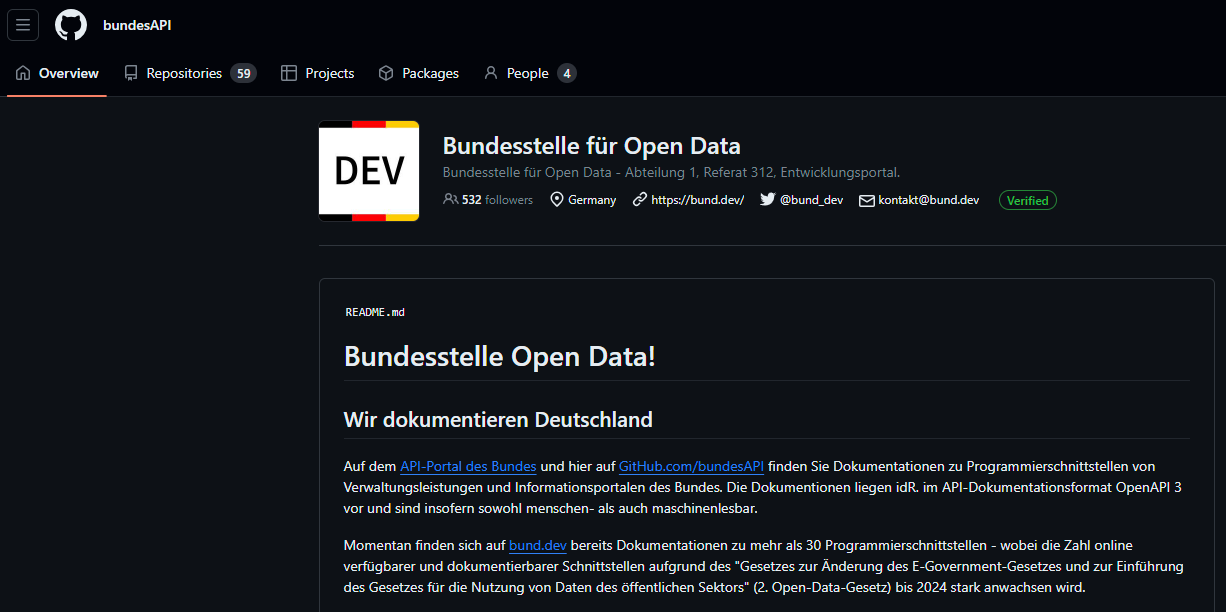

In [ ]:
# Aktuelle Warnungen abfragen und als JSON parsen
data = requests.get("https://s3.eu-central-1.amazonaws.com/app-prod-static.warnwetter.de/v16/gemeinde_warnings_v2.json").json()

In [ ]:
data["warnings"]

## Pandas DataFrame erstellen und Geometrien konvertieren

![title](https://sademoportalwe.blob.core.windows.net/notebook-data/NB_PandasData.png)
<center><i>Quelle: pandas.pydata.org (bearbeitet)

In [ ]:
# Data Frame aus JSON Response erstellen
warnings_features_df = pd.DataFrame(data["warnings"])
warnings_features_df

#### Funktion um Geometrie zu erstellen. ACHTUNG! Kein Anspruch auf Korrektheit, da schwierig zu verarbeitendes Format. Verbesserungsvorschläge herzlich willkommen!

In [ ]:
def createPolygon(polXY):
    # Auf Array mit kommaseparierten Koordinaten zugreifen
    polXY = polXY[0]["polygon"]
    
    # Esri Feature JSON für Polygon anlegen
    shape = {"rings": [[]],"spatialreference" : {"wkid" : 4326}}
    
    #Durch Array mit Koordinaten in 2er Schritten (Y,X Paar) durchiterieren
    i=0
    while i < len(polXY):
        
        # Koordinatenpaar als Array mit X,Y erstellen (muss getauscht werden)
        a = []
        a.append(polXY[i+1])
        a.append(polXY[i])
        
        # Da innere Ringe der Polygone einfach an die Liste angehangen werden, diese auf Basis des Abstandes zwischen den Punkten filtern.
        # Aktuelle Annahme: Zuerst wird der äußere Ring geschlossen und anschließend mit größerer Distanz in den inneren Ring gesprungen.
        # Hier wird aktuell gestoppt und nur der äußere Ring verarbeitet, falls der Sprung entsprechend der Distanz groß genug ist.
        if (i>1):
            disX = abs(a[0] - polXY[i-1])
            disY = abs(a[1] - polXY[i-2])
            if (disX > 0.2 or disY > 0.2):
                print(disX, disY)
                break

        # Koordinatenpar zu Polygon JSON hinzufügen
        shape["rings"][0].append(a)
        i = i+2
        
    # Geometrie aus Polygon JSON erstellen
    shape["rings"][0].append([polXY[1],polXY[0]])
    pol = Geometry(shape)
    
    # Polygone zur besseren Performance generalisieren
    if pol.point_count >= 3:
        pol = pol.generalize(0.02)
    return pol

In [ ]:
# Geometrien in DataFame als SHAPE Spalte hinzufügen
warnings_features_df["SHAPE"] = warnings_features_df["regions"].apply(createPolygon)

## Spatially Enabled Data Frame erstellen

<img src="https://sademoportalwe.blob.core.windows.net/notebook-data/NB_PandasGlobe.png" style="width: 600px;"/>

In [ ]:
# Über set_geometry einen Spatially Enabled DataFrame generieren
warnings_features_df.spatial.set_geometry("SHAPE",sr=4326,inplace=True)
warnings_features_df

In [ ]:
# Attribute konvertieren (Zeitstempel) oder löschen (Regions, URL)
warnings_features_df["start"] = pd.to_datetime(warnings_features_df['start'], unit='ms')
warnings_features_df["end"] = pd.to_datetime(warnings_features_df['end'], unit='ms')
warnings_features_df.drop(["regions","urls"],axis=1,inplace=True)
warnings_features_df

## Räumliche Analysen durchführen

### Bundesländer aus Living Atlas hinzufügen und nach NRW filtern

In [ ]:
# Item Added From Toolbar
# Title: Bundesländergrenzen 2022 | Type: Feature Service | Owner: esri_DE_content
item = gis.content.get("c2c6293823d247f6844bb3a29e7d6e37")
item

In [ ]:
# Nach BL in diesem Beispiel NRW filtern und dieses für eine bessere Performance generalisieren
nrw = item.layers[0].query(where="AGS='05'",out_sr=4326).sdf
nrw = nrw.loc[0]["SHAPE"].generalize(0.1)
display(nrw)

### Verschneidung mit Wetterwarnungs Polygonen

In [ ]:
# Für alle Warnungen im Spatially Enabled Data Frame testen ob diese im BL liegen und nicht nur kleine Artefakte sind
warnings_features_nrw_df = warnings_features_df[(warnings_features_df['SHAPE'].apply(lambda x: x.overlaps(nrw) if x.point_count >= 5 else False))]
warnings_features_nrw_df

## Ergebnisse Visualisieren

In [ ]:
m = gis.map()
m

In [ ]:
# To Do: Wird aus irgendeinem Grund noch nicht ordentlich angezeigt
warnings_features_nrw_df.spatial.plot(m)

## FeatureLayer publizieren

In [ ]:
# To Do: FeatureLayer aktualisieren, so dass Notebook über Task automatisiert werden kann.
warnings_features_df.spatial.to_featurelayer("DWD Gemeinde Warnung")